# Decision tree

In this kernel we explore the power of dimensionality reduction for high-dimensional data such as MNIST. We will reduce all 784 pixel features to 2 features and compare the impact it has on the accuracy score. For dimensionality reduction we first use [Truncated Singular Value Decomposition (TSVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition), which is a powerful compression algorithm for matrices such as MNIST digit images. After that we use [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) on the compressed data from TSVD. Luckily we can easily implement these algorithms thanks to libraries such as [scikit-learn](https://scikit-learn.org/stable/). Let's dive in!

Image: an example of t-SNE results on the MNIST dataset with labels. In this kernel we will create our own t-SNE visualization. [[Source](https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/)]

![pics](http://nlml.github.io/images/tsne/tsne-mnist.png)

## Table of Contents

- [Dependencies](#1)
- [Preparation](#2)
- [Metric](#3)
- [Exploratory Data Analysis (EDA)](#4)
- [Baseline model](#5)
- [Dimensionality Reduction (TSVD and t-SNE)](#6)
- [Modeling](#7)
- [Evaluation](#8)
- [Submission](#9)

## Preparation <a id="2"></a>

Loading in files. Note that we concatenate the training and testing data because we would like to train our dimensionality reduction algorithms on all the data we have.

In [22]:
!pip install pydotplus


In [19]:
!pip install six

In [79]:
from six import StringIO
# import pydotplus
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing


In [60]:
# Modeling and Machine Learning


from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
#from sklearn.externals.six import StringIO
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


import torchvision

# Load Data
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False)

training_data = train_dataset.train_data.numpy()[:5000].reshape(5000, -1)
# (5000, 28, 28) -> (5000, 784)
training_label = train_dataset.train_labels[:5000].numpy()

test_data = test_dataset.test_data.numpy()[:5000].reshape(5000, -1)
test_label = test_dataset.test_labels[:5000].numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [42]:
#Print training data size
print(training_data.dtype)
print('Training data size: ', training_data.shape)
print('Training data label size:', training_label.shape)
print('Training data size: ', test_data.shape)
print('Training data label size:', test_label.shape)

uint8
Training data size:  (5000, 784)
Training data label size: (5000,)
Training data size:  (5000, 784)
Training data label size: (5000,)


In [33]:
print(len(training_data))

5000


## Exploratory Data Analysis (EDA) <a id="4"></a>

The data consists of a tabular format where every pixel is a feature. A single decision tree is naturally unequipped to handle that many features. That is why we use t-SNE to reduce all 784 features to 2 t-SNE features.

The visualization below shows that the target distribution is quite evenly distributed. This is convenient becaused now we don't have to perform [additional preprocessing](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18).

In [ ]:
# sns.countplot(train_label)

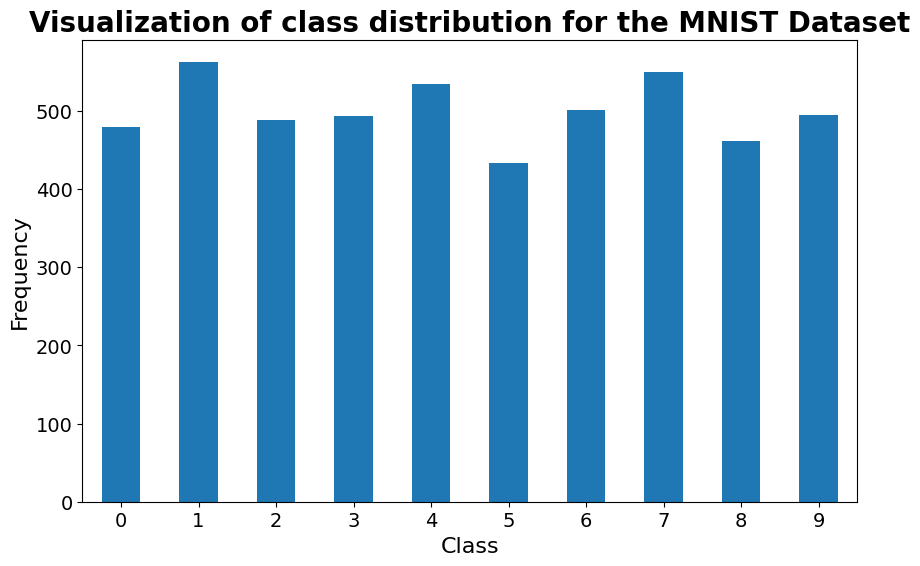

In [12]:
# Visualize target distribution
train_label = pd.Series(training_label)
train_label.value_counts().sort_index().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Visualization of class distribution for the MNIST Dataset', fontsize=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Frequency', fontsize=16);

## Baseline Model <a id="5"></a>

As a reference we train a single decision tree on all the pixel features and check what score we get. Later we train a decision tree with exactly the same hyperparameters on the t-SNE features. This allows us to compare how big the jump in accuracy is.

In [13]:
# Train baseline decision tree model
clf = DecisionTreeClassifier()

clf.fit(training_data, training_label)

DecisionTreeClassifier()

In [15]:
# Evaluate the baseline model
from sklearn import metrics
y_pred = clf.predict(test_data)

print("Accuracy without best param:", metrics.accuracy_score(y_true=test_label, y_pred=y_pred), "\n")


Accuracy without best param: 0.7486 



We will write the top level of the decision tree to a .png file using [sklearn's export_graphviz function](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) and [pydotplus](https://pydotplus.readthedocs.io/). Check out the output of this kernel to see the visualized decision tree.

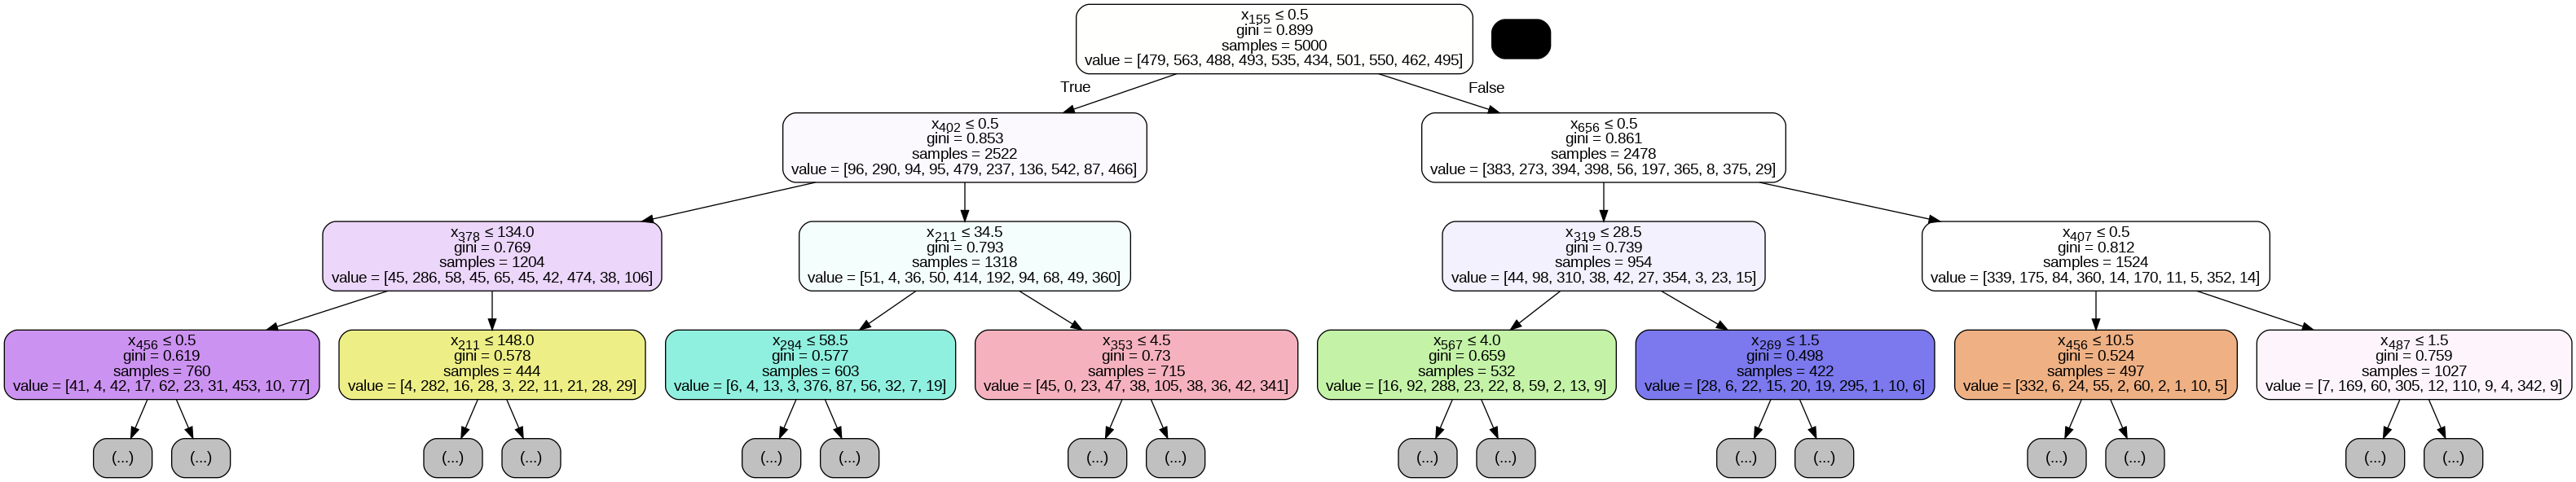

In [24]:
# Convert Decision Tree to visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Create PNG file
Image(graph.create_png())

In [ ]:
# Save PNG file
graph.write_png("mnist_decision_tree_baseline.png");

## Gridsearch for the navie model

In [138]:
# creating a KFold object with 5 splits
folds = KFold(n_splits = 5, shuffle = True, random_state = 10)

# Set the parameters by cross-validation
hyper_params = [ {
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}]



# set up GridSearchCV()
model_cv1 = GridSearchCV(estimator = clf,
                        param_grid = hyper_params,
                        scoring= 'accuracy',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

In [139]:
# fit the model
model_cv1.fit(training_data, training_label)

# printing the optimal accuracy score and hyperparameters
best_score = model_cv1.best_score_
best_hyperparams = model_cv1.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))



Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best test score is 0.7846 corresponding to hyperparameters {'max_depth': 9, 'min_samples_leaf': 1}


## Dimensionality Reduction (TSVD and t-SNE) <a id="6"></a>

As mentioned at the beginning of this kernel we first compress the data using Truncated Singular Value Decomposition (TSVD). The reason we don't perform t-SNE on the full dataset is because of computation and stability. TSVD is ideal for if you want to compress [sparse data](https://en.wikipedia.org/wiki/Sparse_matrix). If you are dealing with dense data then [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is often a better dimensionality reduction technique.

In [70]:
# Perform Truncated Singular Value Decomposition (TSVD) on all features
# This will reduce the amount of features to 50 and will simplify t-SNE
tsvd_train = TruncatedSVD(n_components=700).fit_transform(training_data)
tsvd_test = TruncatedSVD(n_components=700).fit_transform(test_data)


Let's see what score we get with only the TSVD reduction to 50 components.

In [71]:
# Train model with t-svd features
clf2 = clf.fit(tsvd_train, training_label)

In [72]:
# Evaluate model with the 50 TSVD features and compare to the baseline model

y_pred2 = clf2.predict(tsvd_test)

print("Accuracy without best param:", metrics.accuracy_score(y_true=test_label, y_pred=y_pred2), "\n")


Accuracy without best param: 0.2838 



We can see that by applying TSVD we lose information and the same decision tree classifier leads to a worse performance. However, we will see later that after applying t-SNE and using those features the same deicision tree classifier will lead to remarkable results.

After compressing the 784 pixel features to 50 features we train the t-SNE algorithm. Note that we can train the algorithm on the train and testing data combined. We don't need the target because of t-SNE's [unsupervised nature](https://en.wikipedia.org/wiki/Unsupervised_learning).

In [78]:
# Fit t-SNE on the Truncated SVD reduced data (50 features)
tsne = TSNE()
transformed_train = tsne.fit_transform(tsvd_train)
transformed_test = tsne.fit_transform(tsvd_test)

In [111]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
tsne_train = scaler.fit_transform(transformed_train)
tsne_test = scaler.fit_transform(transformed_test)


In [112]:
tsne_train = pd.DataFrame(tsne_train, columns=['component1', 'component2'])
tsne_test = pd.DataFrame(tsne_test, columns=['component1', 'component2'])

In [119]:
print(tsne_train)

      component1  component2
0       0.169338    0.106758
1       0.725841    0.340649
2       0.132378   -0.852080
3      -0.876697    0.153468
4      -0.096252   -0.443446
...          ...         ...
4995   -0.771745   -0.437562
4996    0.035971    0.719514
4997   -0.438894    0.693849
4998   -0.526627    0.080565
4999   -0.486000    0.637582

[5000 rows x 2 columns]


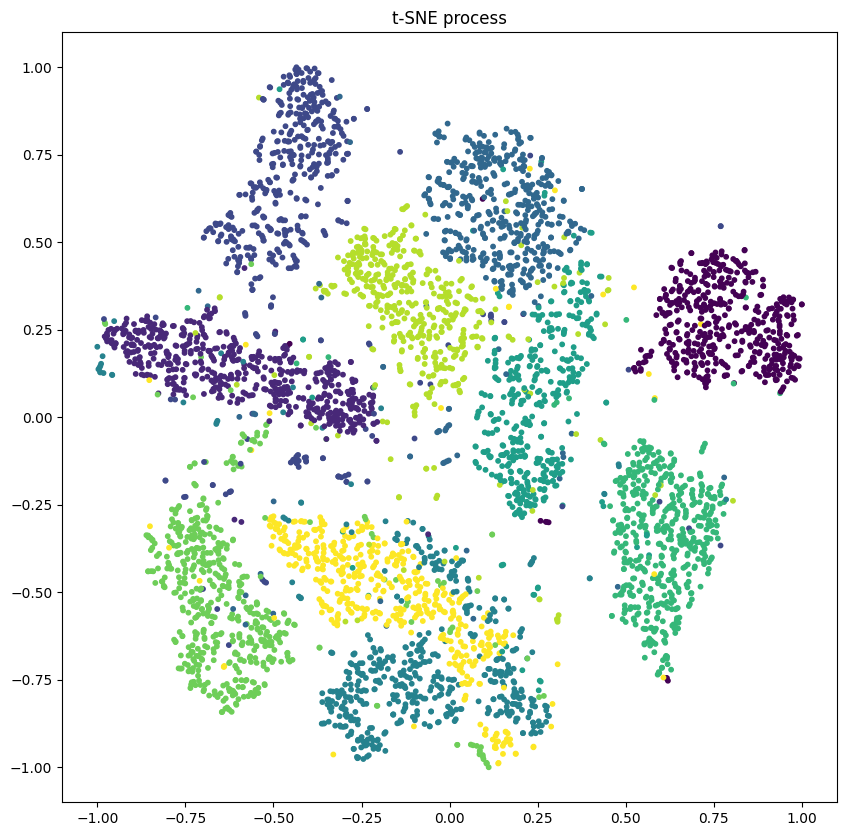

In [94]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.set_title('t-SNE process')
ax.scatter(tsne_train[:,0], tsne_train[:,1] , c=train_label, s=10)


Besides compressing data and making simple algorithms more effective on high-dimensional data, t-SNE can also be used to create intuitive and beautiful visualizations of data. As you can see in the graph below the classes are clearly distinct from each other when compressed into a 2-dimensional space. Also, images that are similar like 3 and 9 are closer to each other than 0 and 7. In the MNIST dataset, some 7's look pretty much like a 1 and this is reflected in the t-SNE visualization.

A downside of creating a classifiers using compressed data can be that a model like a decision tree becomes less interpretable. We don't know which specific feature influences the result because all features are made up of a combination of features. We can counter this by compressing groups of features that have a similar meaning and have a high correlation with each other.

In [125]:
value = tsne_train
print(value)

      component1  component2
0       0.169338    0.106758
1       0.725841    0.340649
2       0.132378   -0.852080
3      -0.876697    0.153468
4      -0.096252   -0.443446
...          ...         ...
4995   -0.771745   -0.437562
4996    0.035971    0.719514
4997   -0.438894    0.693849
4998   -0.526627    0.080565
4999   -0.486000    0.637582

[5000 rows x 2 columns]


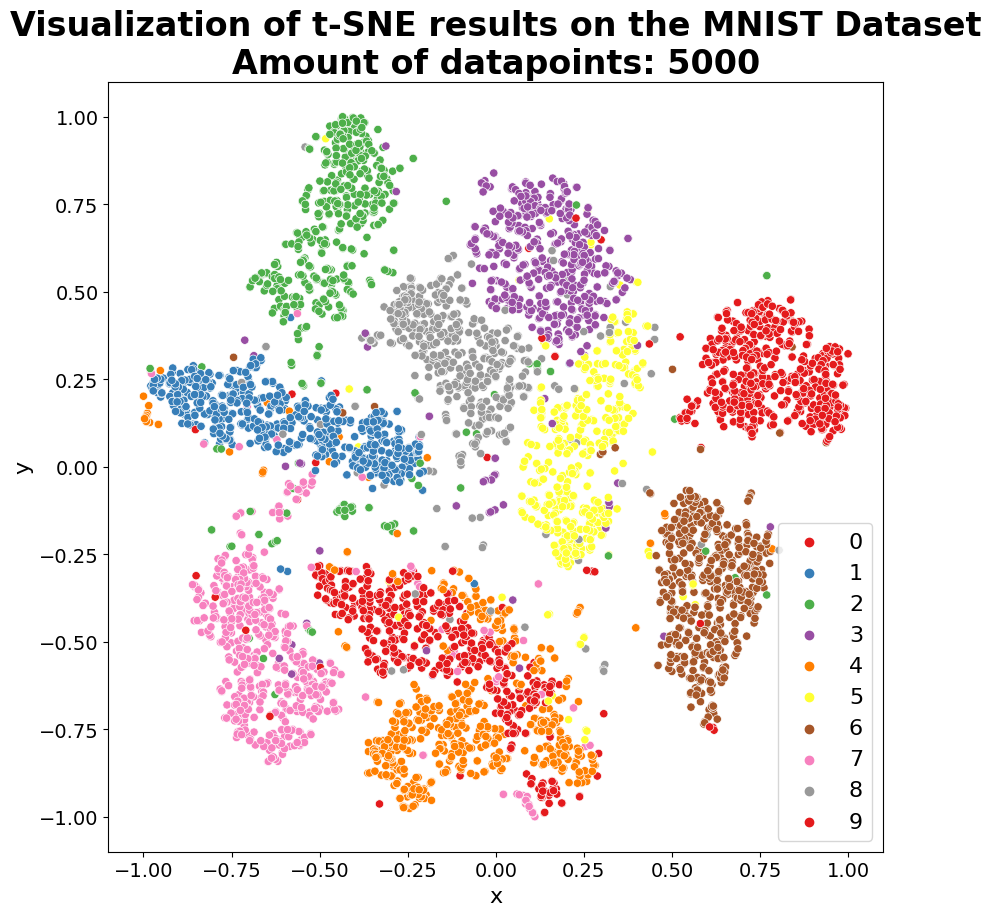

In [130]:
# Visualize the results for t-SNE on MNIST
plt.figure(figsize=(10, 10))
plt.title(f"Visualization of t-SNE results on the MNIST Dataset\n\
Amount of datapoints: {len(tsne_train)}", fontsize=24, weight='bold')
sns.scatterplot(x ="component1", y = "component2",
                data=tsne_train, hue=train_label,
                palette="Set1", legend="full")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.legend(fontsize=16);

## Modeling <a id="7"></a>

Now that the t-SNE features are created we train a new [decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with the same hyperparameters.

In [131]:
# Train model with t-sne features
clf3 = clf.fit(tsne_train, train_label)

## Evaluation <a id="8"></a>

We can easily see that the new decision tree with the t-SNE features is less prone to overfitting and results in a substantially higher accuracy score using the same hyperparameters!

In [132]:
# Evaluate model with the 50 TSVD features and compare to the baseline model

y_pred3 = clf3.predict(tsne_test)

print("Accuracy without best param:", metrics.accuracy_score(y_true=test_label, y_pred=y_pred3), "\n")


Accuracy without best param: 0.5544 



## Gridsearch for model after demension reduction <a id="8"></a>

In [133]:
# creating a KFold object with 5 splits
folds = KFold(n_splits = 5, shuffle = True, random_state = 10)

# Set the parameters by cross-validation
hyper_params = [ {
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}]



# set up GridSearchCV()
model_cv = GridSearchCV(estimator = clf3,
                        param_grid = hyper_params,
                        scoring= 'accuracy',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)



In [135]:
model_cv.fit(tsne_train, train_label)

# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best test score is 0.916 corresponding to hyperparameters {'max_depth': 10, 'min_samples_leaf': 3}


## Conclusion <a id="9"></a>

:- In this case, we have got a classification rate:
 - 74.86%, which is with all in default.
 - 78.46%, which is with GridsearchCV() for best hyper_params.
 - 28.38%, which introduces TSVD for dimensionality reduction.
 - 55.44%, which introduces T-SNE for dimensionality reduction.
 - 91.60%, which introduces T-SNE + GridsearchCV().